# Dogs vs. Cats Kaggle competition

In [57]:
import glob
import os
import ipdb
from matplotlib import pyplot as plt
%matplotlib inline

## Setup make train/test/valid sets

In [20]:
DATA = '/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats'
%cd $DATA
%cd train
%pwd

/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats
/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats/train


u'/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats/train'

### validation from train

In [18]:
g = glob.glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000):
    os.rename(shuf[i], DATA+'/valid/' + shuf[i])

### sample from train

In [27]:
from shutil import copyfile
g = glob.glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200):
    copyfile(shuf[i], DATA +'/sample/train/' + shuf[i])

### sample from valid

In [28]:
%cd $DATA/valid

/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats/valid


In [30]:
g = glob.glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA+'/sample/valid/' + shuf[i])

## divide classes into cats and dogs folders

In [31]:
#Divide cat/dog images into separate directories

%cd $DATA/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

# Create single 'unknown' class for test set
%cd $DATA/test
%mv *.jpg unknown/

/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats/sample/train
/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats/sample/valid
/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats/valid
/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats/train
/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats/test
usage: mv [-f | -i | -n] [-v] source target
       mv [-f | -i | -n] [-v] source ... directory


In [41]:
#Set path to sample/ path if desired
path = DATA +'/sample/'
test_path = DATA + '/test/' #We use all the test data
results_path = DATA + '/results/'
train_path = path + '/train/'
valid_path = path + '/valid/'

# Training VGG

In [42]:
import vgg16
from vgg16 import Vgg16

In [37]:
vgg = Vgg16()

In [43]:
batch_size = 64
no_of_epochs=3

In [44]:
batches = vgg.get_batches(train_path, batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)
vgg.finetune(batches)
vgg.model.optimizer.lr = 0.01

Found 200 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [45]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print "Running epoch: %d" % epoch
    vgg.fit(batches, val_batches, nb_epoch=1)
    latest_weights_filename = 'ft%d.h5' % epoch
    vgg.model.save_weights(results_path+latest_weights_filename)
print "Completed %s fit operations" % no_of_epochs

Running epoch: 0
Epoch 1/1
200/200 [==============================] - 126s - loss: 1.0876 - acc: 0.7700 - val_loss: 0.6459 - val_acc: 0.9600
Running epoch: 1
Epoch 1/1
200/200 [==============================] - 133s - loss: 0.5845 - acc: 0.9350 - val_loss: 0.7167 - val_acc: 0.9400
Running epoch: 2
Epoch 1/1
200/200 [==============================] - 132s - loss: 0.3849 - acc: 0.9750 - val_loss: 0.6558 - val_acc: 0.9600

# Prediction

In [54]:
#ls *.jpg|gshuf -n 200|xargs -L 1 -I % cp % ../../sample/test/
test_path = DATA + '/sample/test/'
batches, preds = vgg.test(test_path, batch_size = batch_size*2)
print test_path

Found 200 images belonging to 1 classes.
/Users/slegroux1/Projects/Kaggle/Dogs-vs-cats/dogs-vs-cats/sample/test/


In [55]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print preds[:5]

filenames = batches.filenames
print filenames[:5]

[[  1.00000000e+00   6.39480407e-19]
 [  4.41648983e-35   1.00000000e+00]
 [  4.77457596e-22   1.00000000e+00]
 [  1.00000000e+00   6.01532888e-16]
 [  1.00000000e+00   7.94433934e-40]]
['unknown/100.jpg', 'unknown/1002.jpg', 'unknown/10119.jpg', 'unknown/10133.jpg', 'unknown/10184.jpg']


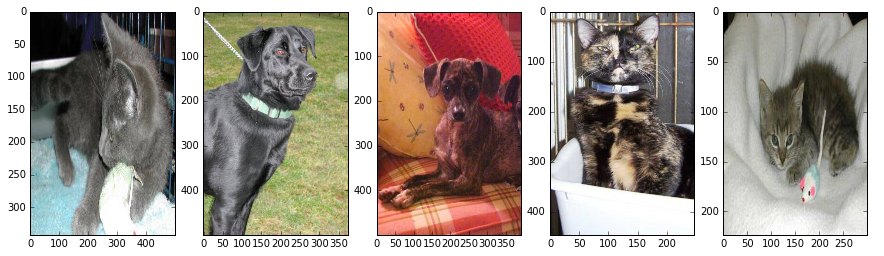

In [75]:
f, axes = plt.subplots(1,5, figsize=(15,4))
for idx, img in enumerate(filenames[:5]):
    axes[idx].imshow(plt.imread(img), aspect = 'auto')

In [76]:
# save data
import bcolz

fname = results_path + 'test_preds.dat'
c=bcolz.carray(preds, rootdir=fname, mode='w')
c.flush()

fname = results_path + 'filenames.dat'
c=bcolz.carray(filenames, rootdir=fname, mode='w')
c.flush()

In [77]:
# load data
fname = results_path + 'test_preds.dat'
preds = bcolz.open(fname)[:]
fname = results_path + 'filenames.dat'
filenames = bcolz.open(fname)[:]

In [78]:
#Grab the dog prediction column
isdog = preds[:,1]
print "Raw Predictions: " + str(isdog[:5])
print "Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)])
print "Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)])

Raw Predictions: [  6.39480407e-19   1.00000000e+00   1.00000000e+00   6.01532888e-16
   7.94433934e-40]
Mid Predictions: [ 0.59462249]
Edge Predictions: [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [79]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05 (because of log loss)
isdog = isdog.clip(min=0.05, max=0.95)

In [80]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

In [87]:
print ids
subm = np.stack([lambda: xids,isdog], axis=1)
print subm[:5]

[  100  1002 10119 10133 10184 10258 10272 10276 10348 10374 10497 10517
 10538 10592 10629 10726  1076 10796 10869 10944 10977 10987 11000 11017
 11236 11238  1126 11317 11337 11358 11380 11384 11449  1152 11593 11823
 11858 11914 12079 12174 12346 12445 12477  1248 12489  1290  1420  1488
  1693  1710  1723  1764  1886  2114  2121   217  2209  2390  2418  2508
   251  2549   256  2608  2648  2830  2864  2919  3073  3269  3345   344
  3466  3473  3614  3694  3749  3908  3960  3992  4034  4067  4112  4168
   418  4228  4247  4261  4298  4341  4447  4489  4491  4522  4607  4670
  4704  4722  4798  4842  4889  5010  5038  5043   513  5157  5165  5224
  5340  5399  5420  5434  5452  5657  5705  5716   572  5733  5754  5782
  5819  6024  6045  6176  6212  6228  6303  6367  6371  6380  6447  6481
  6483  6520  6551   658    66  6695  6753  6781  6912  6954  6991  7340
  7386  7417  7491  7600  7612  7622  7644  7652  7737  7915    80  8018
  8034  8045  8107  8186  8353  8396  8405  8422  8

TypeError: only length-1 arrays can be converted to Python scalars

In [ ]:
%cd $DATA
submission_file_name = 'submission1.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')